This work is inspired blog post of Maciej D. Korzec https://towardsdatascience.com/recommending-similar-images-using-pytorch-da019282770c

In [1]:
# Some imports, which were needed to run the code on the Puhti supercomputer
# Install these via pip if you don't have them already
'''
import sys
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
'''

'\nimport sys\n!{sys.executable} -m pip install torchvision\n!{sys.executable} -m pip install tqdm\n!{sys.executable} -m pip install numpy\n!{sys.executable} -m pip install pandas\n!{sys.executable} -m pip install matplotlib\n'

In [2]:
# Imports
import os
import torch
import pandas as pd
import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
import random
from PIL import Image
from torchvision import transforms, models
from tqdm import tqdm
from numpy.testing import assert_almost_equal

In [3]:

# Needed input dimensions for the CNN
# PyTorch's documentation suggests resolution of at least 224 x 224
inputDim = (224,224)

# Directory, from where the images to be analyzed are taken
# Change accordingly to your needs and folder structure
inputDir = "../test-images/botanical-large"

# Output directory for the similar images
# Change accordingly to your needs and folder structure
inputDirCNN = "CNN"

In [4]:
os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

# This will take some time and probably is the bottleneck of the code
# Could be investigated, if can be made faster
print("Transforming images for the resnet:")
for imageName in tqdm(os.listdir(inputDir)):
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    # Copy the rotation information metadata from original image and save, else your transformed images may be rotated
    newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()


Transforming images for the resnet:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [16:27<00:00, 19.18it/s]


In [5]:
# The class for the resnet
class Img2VecResnet18():
    def __init__(self):
        
        # If you dont have an access to a GPU, use the CPU version
        self.device = torch.device("cpu") 
        # self.device = torch.device("cuda") 
        self.numberFeatures = 512
        # Also other models are available, see more in PyTorch's documentation
        self.modelName = "resnet-18"

        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # These values are suggested by PyTorch's documentation
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o):
            embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        cnnModel = models.resnet18(weights="DEFAULT")
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        return cnnModel, layer
        

# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir(inputDirCNN)):
    I = Image.open(os.path.join(inputDirCNN, image)).convert("RGB")
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close() 


Converting images to feature vectors:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [12:26<00:00, 25.37it/s]


In [6]:
# Define a function that calculates the cosine similarity entries in the similarity matrix
def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [7]:
# the number of top similar images to be stored
# Can be changed according to your own needs and interest
k = 5

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
print("Counting similarity values for images:")
for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
similarNames_path = "similarNames.pkl"
similarValues_path = "similarValues.pkl"
similarNames.to_pickle(similarNames_path)
similarValues.to_pickle(similarValues_path)

Counting similarity values for images:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18949/18949 [00:40<00:00, 463.20it/s]


In [8]:
# open a file, where you stored the pickled data
file = open(similarNames_path, 'rb')
simNames = pickle.load(file)
file.close()

file = open(similarValues_path, 'rb')
simValues = pickle.load(file)
file.close()

In [9]:
# Set axes when showing the compared and similar images
def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 8)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 8)
    ax.set_xticks([])
    ax.set_yticks([])

# Get the similar image files and their corresponding similarity scores
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))

# Plot the similar images
def plotSimilarImages(image, similarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(10, 20))
    
    # cut-off value, which determines how similar images we want
    # Can be adjusted between 0 and 1 how similar images are wanted
    cutoff_value = 0.93

    # now plot the  most similar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            # If not accurate enough, e.g,smaller than cutoff, dont print the image or write data 
            if simValues[j-1] < cutoff_value:
                continue
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])

        img = img.convert('RGB')
        plt.imshow(img)
        img.close()

    plt.show()

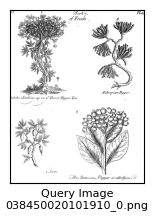

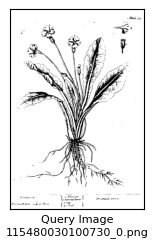

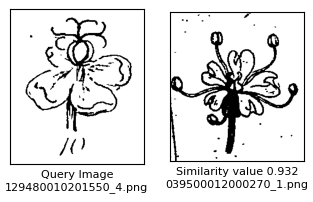

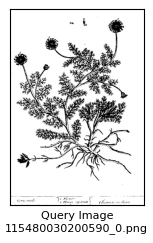

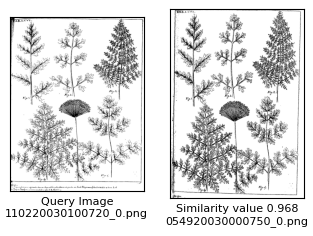

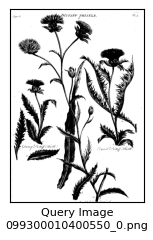

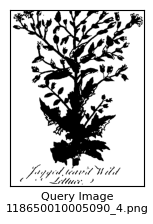

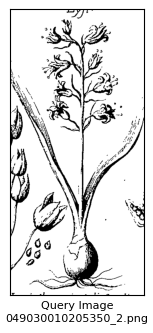

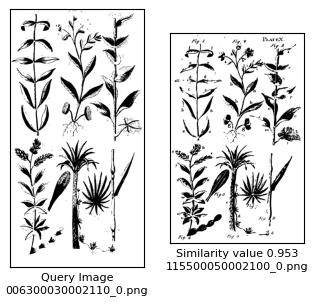

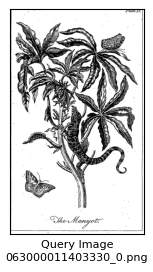

In [12]:
# take three examples from the provided image set and plot
folder_path = "../test-images/botanical-large"

# Print the original "query image" and then the 4 most similar images (have the highest similarity score)
numCol = 5
numRow = 1

# How many images are scanned, can be adjusted
# With a large number might take a reasonable amount of time
num_files = 10
all_files = os.listdir(folder_path)

# Shuffle the list of files randomly
random.shuffle(all_files)
selected_files = all_files[:num_files]

# Go through the image, and plot similar images
for image in selected_files:
    plotSimilarImages(image, simNames, simValues)
    

In [ ]:
# Print the filenames of the similar images
similarNames